In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output


In [2]:
cuda2 = False # torch.cuda.is_available() can be used to check if a gpu is available - I just set it to False
batch_size2 = 128
log_interval2 = 10
epochs2 = 4 # 10

torch.manual_seed(1) # args.seed

device = torch.device("cuda" if cuda2 else "cpu") # args.cuda
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda2 else {} # args.cuda

# Get train and test data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size2, shuffle=True, **kwargs)

In [3]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc1a = nn.Linear(400, 100)
        self.fc21 = nn.Linear(100, 2) # Latent space of 2D
        self.fc22 = nn.Linear(100, 2) # Latent space of 2D
        self.fc3 = nn.Linear(2, 100) # Latent space of 2D
        self.fc3a = nn.Linear(100, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        temp = self.decode(z).view(-1, 1, 28, 28)
        return temp, mu, logvar

In [4]:
# Define CVAE model
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Conv2d(1, 32, kernel_size=(
            3, 3), stride=2, padding=1)  # nn.Linear(784, 400)
        self.fc1a = nn.Conv2d(32, 64, kernel_size=(
            3, 3), stride=2, padding=1)  # nn.Linear(400, 100)
        W, H = 7, 7
        self.fc21 = nn.Linear(64 * W * H, 2)  # Latent space of 2D
        self.fc22 = nn.Linear(64 * W * H, 2)  # Latent space of 2D
        self.fc3 = nn.Linear(2, 64 * W * H)  # Latent space of 2D
        self.fc3a = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.fc4 = nn.ConvTranspose2d(
            32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        h2 = h2.view(-1, 7 * 7 * 64)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = h3.view(-1, 64, 7, 7)
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [61]:
def conv_dims(in_dim, padding, kernel_size, dilation, stride):
    return torch.floor((torch.tensor(in_dim + 2 * padding - dilation * (kernel_size -1) -1)/stride) + 1)

In [62]:
def conv_t_dims(in_dim, padding, kernel_size, dilation, stride, output_padding):
    return (in_dim -1) * stride - 2 * padding + dilation * (kernel_size -1) + output_padding + 1

In [86]:
conv_dims(28, 0, 5, 1, 1), conv_dims(24, 0, 5, 1, 1)


(tensor(24.), tensor(20.))

In [98]:
conv_t_dims(20, 0, 5, 1, 1, 0), conv_t_dims(24, 0, 5, 1, 1, 0)


(24, 28)

In [91]:
# Define CVAE model
class CVAE2(nn.Module):
    def __init__(self):
        super(CVAE2, self).__init__()

        self.fc1 = nn.Conv2d(1, 16, kernel_size=4, stride=2)
        self.fc1a = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        W, H = 5, 5
        self.fc21 = nn.Linear(32 * W * H, 2)  # Latent space of 2D
        self.fc22 = nn.Linear(32 * W * H, 2)  # Latent space of 2D
        self.fc3 = nn.Linear(2, 32 * W * H)  # Latent space of 2D
        self.fc3a = nn.ConvTranspose2d(
            32, 16, kernel_size=5, stride=2)
        self.fc4 = nn.ConvTranspose2d(
            16, 1, kernel_size=4, stride=2)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        h2 = h2.view(-1, 5 * 5 * 32)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = h3.view(-1, 32, 5, 5)
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [102]:
# Define CVAE model
class CVAE3(nn.Module):
    def __init__(self):
        super(CVAE3, self).__init__()

        self.fc1 = nn.Conv2d(1, 16, kernel_size=5)
        self.fc1a = nn.Conv2d(16, 32, kernel_size=5)
        W, H = 20, 20
        self.fc21 = nn.Linear(32 * W * H, 2)  # Latent space of 2D
        self.fc22 = nn.Linear(32 * W * H, 2)  # Latent space of 2D
        self.fc3 = nn.Linear(2, 32 * W * H)  # Latent space of 2D
        self.fc3a = nn.ConvTranspose2d(
            32, 16, kernel_size=5)
        self.fc4 = nn.ConvTranspose2d(
            16, 1, kernel_size=5)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc1a(h1))
        h2 = h2.view(-1, 20 * 20 * 32)
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h3 = h3.view(-1, 32, 20, 20)
        h4 = F.relu(self.fc3a(h3))
        return torch.sigmoid(self.fc4(h4))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [47]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, l = 1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + l * KLD  # -ELBO if l = 1, if l = 0 then we have simply the log likelihood of x given z 

def train(model, optimizer, train_loader, epoch, l = 1):
    # so that everything has gradients and we can do backprop and so on...
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()  # "reset" gradients to 0 for text iteration
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, l)
        loss.backward()  # calc gradients
        train_loss += loss.item()
        optimizer.step()  # backpropagation
    clear_output(wait=True)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(model, test_loader, l = 1, mean = True, mse = False):
    model.eval()
    log_prob = 0
    mse_loss = 0
    with torch.no_grad():  # no_grad turns of gradients...
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            log_prob += - loss_function(recon_batch, data, mu, logvar, l).item()
            mse_loss += torch.nn.functional.mse_loss(recon_batch, data)
    if mean :
        log_prob /= len(test_loader.dataset)
        mse_loss /= len(test_loader.dataset)
    print('====> Test set log likelihood: {:.8f}'.format(log_prob))
    print('====> Test set mse loss: {:.8f}'.format(mse_loss))
    return log_prob, mse_loss


def model_train(model, optimizer, train_loader, test_loader, epochs):
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_loader, epoch, l = 1)
        log_prob, mse_loss = test(model, test_loader, l = 0, mean = True)
        with torch.no_grad():
            sample = torch.randn(64, 2).to(device)  # 20 -> 2
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')
    return log_prob, mse_loss

In [105]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)
class CVAE4(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(CVAE4, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [6]:
vae_model = VAE().to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
# train some shit

cvae_model = CVAE().to(device)
cvae_optimizer = optim.Adam(cvae_model.parameters(), lr=1e-3)
# train more shit
num_epochs = 100

In [7]:
log_prob_vae, mse_loss_vae = model_train(vae_model, vae_optimizer, train_loader, test_loader, num_epochs)

====> Epoch: 10 Average loss: 144.6963
====> Test set log likelihood: -138.72355093
====> Test set mse loss: 0.00030526


In [104]:
log_prob_cvae, mse_loss_cvae = model_train(cvae_model, cvae_optimizer, train_loader, test_loader, num_epochs)

====> Epoch: 8 Average loss: 155.4486
====> Test set log likelihood: -150.87224915
====> Test set mse loss: 0.00034708


KeyboardInterrupt: 

# Qualitative results

## VAE

In [9]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B, 2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))

    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k, :, :, :]
        an_img_flat = torch.flatten(an_img)
        mean_img = vae_model.encode(an_img_flat)[0]
        results[l] = mean_img
        l += 1
results = results[:l, :]
all_labels = all_labels[:l]


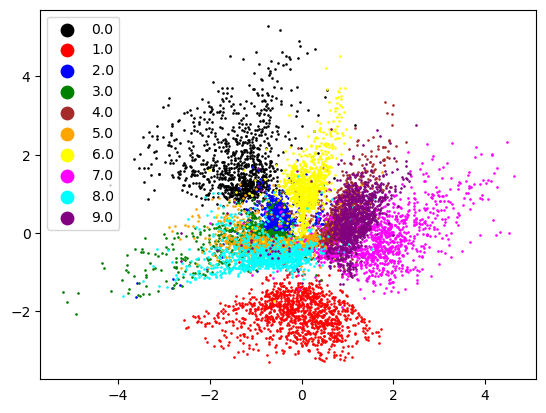

In [10]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:, 0]
scatter_y = results_for_plot[:, 1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown',
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[g], label=g, s=0.8)
ax.legend(markerscale=10)
plt.show()


In [11]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]


In [12]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)


c:\Users\Jacki\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


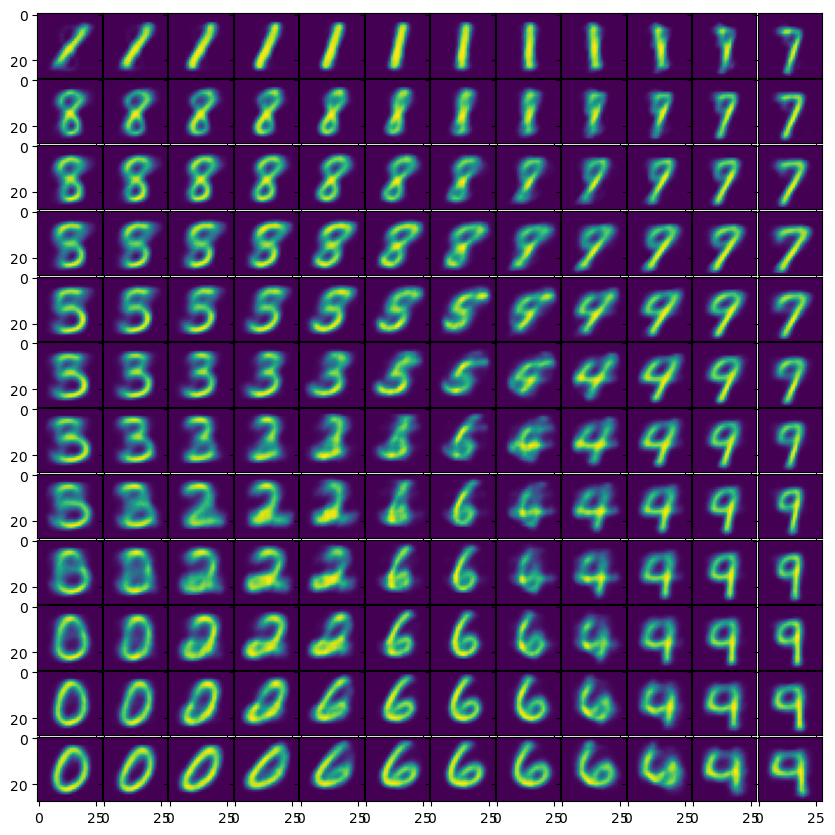

In [13]:
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8), sharex = True, sharey = True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i,j].item()
        y_val = gauss_y[i,j].item()
        im = vae_model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28,28))
        plot_me = im_plt.detach().numpy()
        ax[i][j].imshow(plot_me)

slim=0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()

## CVAE

In [15]:
mnist_test = list(test_loader)
B = len(mnist_test)
results = torch.zeros((128*B, 2))
all_labels = torch.empty(0)
l = 0
for b in range(B):
    labels = mnist_test[b][1]
    all_labels = torch.cat((all_labels, labels))

    images = mnist_test[b][0]
    K = images.shape[0]
    for k in range(K):
        an_img = images[k, :, :, :]
        #an_img_flat = torch.flatten(an_img)
        mean_img = cvae_model.encode(an_img)[0]
        results[l] = mean_img
        l += 1
results = results[:l, :]
all_labels = all_labels[:l]

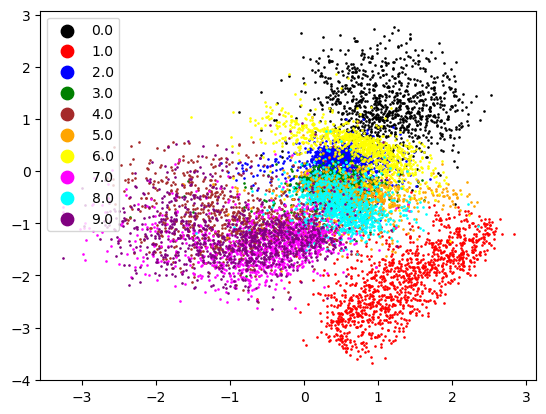

In [16]:
results_for_plot = results.detach().numpy()

scatter_x = results_for_plot[:, 0]
scatter_y = results_for_plot[:, 1]
group = all_labels

cdict = {0: 'black', 1: 'red', 2: 'blue', 3: 'green', 4: 'brown',
         5: 'orange', 6: 'yellow', 7: 'magenta', 8: 'cyan', 9: 'purple'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cdict[g], label=g, s=0.8)
ax.legend(markerscale=10)
plt.show()


In [17]:
M = 12
x = torch.linspace(start=0, end=1, steps=M+2)
x = x[:-1]
x = x[1:]


In [18]:
mesh_x, mesh_y = torch.meshgrid(x, x)
gauss = torch.distributions.normal.Normal(loc=0, scale=1)
gauss_x = gauss.icdf(mesh_x)  # .flip(0)
gauss_y = gauss.icdf(mesh_y)

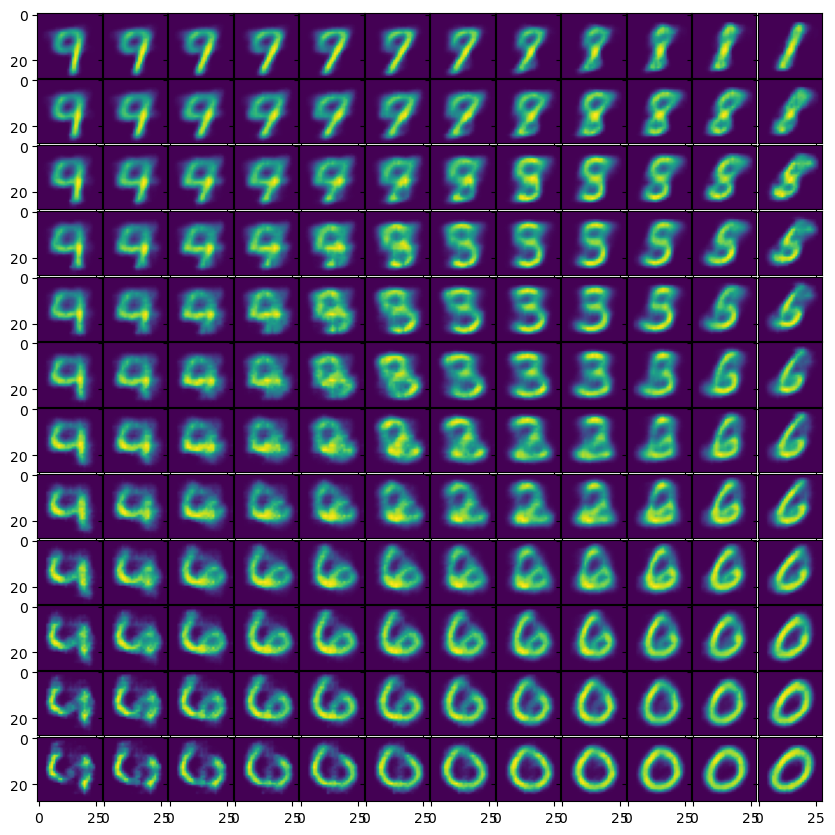

In [23]:
fig, ax = plt.subplots(nrows=M, ncols=M, figsize=(8, 8),
                       sharex=True, sharey=True)
for i in range(M):
    for j in range(M):
        x_val = gauss_x[i, j].item()
        y_val = gauss_y[i, j].item()
        im = cvae_model.decode(torch.Tensor([y_val, x_val]))
        im_plt = im.reshape((28, 28))
        plot_me = im_plt.detach().numpy()
        ax[i][j].imshow(plot_me)

slim = 0.6
plt.tight_layout(pad=-slim, w_pad=-slim, h_pad=-slim)
plt.show()
